**Important Note:** You should have first uploaded the **entire** folder for Problem Sheet 2 to your Google Drive, and open this file with Google Colab through your drive. (You are advised against opening this file directly in Google Colab.)

# Question 1: Classifying digits in the MNIST dataset

We would like to classify the digits from the MNIST dataset, with the data in the form $(x_i, y_i)$ with $x_i \in \mathbb{R}^{d\times d}$ ($d=28$) being the image and $y_i \in \mathbb{R}^K$ ($K=10$) being the labels using a single convolutional neural network with multiple channel. 

**Important:** You can theoretically speed up your code using vectorisation, but I advise against it, as it is extremely hard not to confuse yourselves when multiplying tensors with matrices! Using **for loops** is absolutely fine in this problem sheet!

Once again, we have setup the environments for you. This is done by running the following cell. Remember <font color=red>**always**</font> run the code cell below each time before you attempt this question.

In [1]:
# import necessary package
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import copy
import h5py
from tqdm import tqdm
from random import randint

Remember to also upload the MNIST dataset and run the following cell before attempting this question.

In [2]:
#load MNIST data
MNIST_data = h5py.File('MNISTdata.hdf5', 'r')
x_train = np.float32(MNIST_data['x_train'][:] )
y_train = np.int32(np.array(MNIST_data['y_train'][:,0]))
x_test = np.float32( MNIST_data['x_test'][:] )
y_test = np.int32( np.array( MNIST_data['y_test'][:,0]  ) )

MNIST_data.close()

x_train2 = np.zeros((len(x_train), 28, 28))
x_test2 = np.zeros((len(x_test), 28, 28))

#Re-create 2-D arrays for each image.
for i in range(len(x_train)):
    x_train2[i,:,:] = np.reshape(x_train[i], (28,28) )
   
for i in range(len(x_test)):
    x_test2[i,:,:] = np.reshape(x_test[i], (28,28) )

## Part (a) - implementing a CNN from scratch (without PyTorch)

We will here implement a single-layer CNN with `5` channels, each contains a `3*3` filter, making use of the ReLU activation.

Before doing this task, make sure you are happy with the derivation of the steps of stochastic gradient descent for a single-layer multi-channel convolutional neural network. You may either refer to page 107-114 of the slides for lectures 1-3, or the course lecture notes on neural networks.

**Step 1:** As seen in the lecture, convolution is an important operation in both the forward and backward propagation of CNN. Let us therefore implement a `Convolution` function, which 
- inputs `X` as the image (2D array) we want to convolve with (assuming that it is a square), `F` as a 3D array which contains many 2D filters that are squared in shape and have the same dimensions, and 
- output `Z` as the the convolved array.



In [144]:
from scipy.signal import convolve2d

def Convolution(X, F, C=None, k_F=None, dim=None):
  if C == None:
    C = F.shape[2]        # number of 2D filters 
  if k_F == None:
    k_F = F.shape[1]      # size of square 2D filter
  if dim == None:
    dim = X.shape[0] - k_F + 1    # dimension of picture after convolution 

  Z = np.zeros((dim, dim, C))
#   for c in range(C):
#     for i in range(dim):
#         for j in range(dim):
#             Z[i, j, c] = np.sum(F[:,:,c] * X[i:i + k_F, j: j+k_F]) 
            
  # Perform convolution using SciPy's convolve2d function
  for c in range(C):
    Z[:, :, c] = convolve2d(X, F[:, :, c], mode='valid')

  return Z

**Step 2:** Let us then implement the ReLU activation function, its derivative, as well as the softmax function.

In [145]:
def ReLU_nonlinearity(z):
    H = copy.deepcopy(z)
    # Apply ReLU element-wise
    H[H < 0] = 0
    return H

def ReLU_nonlinearity_derivative(z):
    H = copy.deepcopy(z)
    # Derivative of ReLU is 1 if z > 0, else 0
    H[H <= 0] = 0
    H[H > 0] = 1
    return H

def softmax_function(z):
    e_z = np.exp(z - np.max(z, axis=0, keepdims=True))
    return e_z / e_z.sum(axis=0, keepdims=True)

We are now ready to implement our convolutional neural network as an object called `myCNN`. The remaining steps are followed:

**Step 3:** Initialise the filters `K`, weights `W` and the biases `b` respectively. (*Hint:* the shape of weights `W` is `(self.num_channels, d2, d2)`, where `d2` is an integer to be specified.)

**Step 4:** Implement the `forward` function, which has `X` as the input figure and output
- `p` as the final probability vector
- `V` as the output of convolution
- `H` as $\sigma(V)$, and
- `Z` as $W \cdot H + b$.

**Step 5:** Implement the `backward` function, which has `X` as the input figure, `y` as the labels, `p`, `V`, `H`, `Z` as defined in step 4 as an optional argument, and output `K_grad`, `W_grad` and `b_grad` as the gradient of loss with respect to the filters, weights and biases respectively.

**Step 6:** Complete the `train` function, which inputs the training data (`x_train` and `y_train`) and update the parameters by stochastic gradient descent.

**Step 7:** Complete the `predict` and `test` function. The `predict` function gives out the predicted label given an image input (`x_test`), while the `test` function reports the testing accuracy and generates a confusion matrix when the testing data (`x_test` and `y_test`) are supplied (*Hint:* refer to the relevant codes in Homework 1).

In [167]:
class myConvolutionalNeuralNetwork:
  def __init__(self, input_size=28, num_outputs=10, filter_size=3, num_channels=5, sk=1, sw=1, sb=1):
    self.input_size = input_size
    self.num_outputs = num_outputs
    self.filter_size = filter_size
    self.num_channels = num_channels
    self.sk = sk
    self.sw = sw
    self.sb = sb

    ### Step (3): initialisation
    # Compute the dimension of W
    self.d2 = self.input_size - self.filter_size + 1

    # Now perform the actual initialisation
    self.W = np.random.randn(self.num_outputs, self.d2, self.d2, self.num_channels) / np.sqrt(self.input_size)
    self.K = np.random.randn(self.filter_size, self.filter_size, self.num_channels) / np.sqrt(self.input_size) 
    self.b = np.zeros((self.num_outputs, 1))


  ### Step (4): implement the forward function
  def forward(self, X):
        
    # Compute Z and H  
    Z = Convolution(X, self.K)
    H = ReLU_nonlinearity(Z)
        
    # Compute U for each possible output 
    U = np.zeros((self.num_outputs, 1))
    
    for k in range(0, self.num_outputs): 
        sum = 0
        for c in range(0, self.num_channels):
            for i in range(0, 26):
                for j in range(0, 26):
                    sum+= self.W[k,i,j,c] * H[i,j,c]
        #compute U using W and H
        U[k] = sum + self.b[k]
        
    # Compute probability vector   
    p = softmax_function(U)
    
    return Z, H, U, p


  ### implement the backward function
  def backward(self, X, y, Z=None, H=None, U=None, p=None):

    # perform the forward step if it hasn't been done so
    if (p==None).any() or (U==None).any() or (H==None).any() or (Z==None).any():
      Z, H, U, p = self.forward(X)
    
    #creating one hot encoded matrix (2D) 
    encoded_array = np.zeros((self.num_outputs, y.size))
    encoded_array[y, np.arange(y.size),] = 1.0
  
    #### compute the gradient for b #######
    b_grad = p - encoded_array
    
    #### compute the gradient for W ####### 
    W_grad = np.zeros((self.num_outputs, self.d2, self.d2, self.num_channels))
    
    for k in range(self.num_outputs):
        W_grad[k,:,:,:] = (p[k] - encoded_array[k]) * H
    
    #### compute the gradient for K #######
    delta = np.zeros((self.d2, self.d2, self.num_channels))
    K_grad = np.zeros((self.filter_size, self.filter_size, self.num_channels))
    
    for c in range(0, self.num_channels):
        for i in range(0, self.d2):
            for j in range(0, self.d2):
                delta[i,j, c] = b_grad.T @ self.W[:,i,j,c]
            
    for c in range(0, self.num_channels):
        kernel = ReLU_nonlinearity_derivative(Z[:,:,c]) * delta[:,:, c]
        # apply convolution
        for i in range(0, self.filter_size):
            for j in range(0, self.filter_size):
                K_grad[:,:,c] = np.sum(kernel * X[i:i + self.d2, j: j+self.d2]) # could use einstein sum

    
    return K_grad, W_grad, b_grad


  def train(self, x_train, y_train, LR=.01, num_epochs=1):
    time1 = time.time()

    for epoch in range(num_epochs):
      total_correct = 0
      for n in tqdm(range(len(y_train))): 

        #choose a random index here
        n_random = randint(0,len(x_train)-1)
        x = x_train[n_random] 
        y = y_train[n_random]
        
        # perform a forward pass
        Z, H, U, p = self.forward(x)

        # make a prediction and compute the accuracy
        prediction = np.argmax(p)
        if (prediction == y):
            total_correct += 1

        # perform backward propagation
        K_grad, W_grad, b_grad = self.backward(x, y, Z, H, U, p)
        self.b -= LR * b_grad
        self.W -= LR * W_grad
        self.K -= LR * K_grad

      print(f"Epoch {epoch}: training accuracy {total_correct/len(y_train)}")

    time2 = time.time()
    print(f"Training time is {time2-time1}s.")

  ### implement the predict and test functions
  def predict(self, x_test):
    y_pred = np.zeros(len(y_test))
    for idx in tqdm(range(len(x_test))):
      x = x_test[:,:,idx]
      _, _, _, p = self.forward(x)
      y_pred[idx] = np.argmax(p)
    return y_pred

  def test(self, x_test, y_test, plot_confusion=False):
    y_pred = self.predict(x_test.T)
    total_correct = np.sum(y_pred == y_test)
    accuracy = total_correct/len(y_test)

    if plot_confusion:
        # Compute the confusion matrix
        confusion_matrix, _, _ = np.histogram2d(y_test, y_pred, bins=np.arange(self.num_outputs + 1))

        # Plotting the confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='viridis')
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()

    return accuracy
                        

Once you are happy with the above implementation, run the following cell to see the performance of your implementation. It takes around 8 minutes for me to finish training.

In [165]:
my_CNN = myConvolutionalNeuralNetwork()
my_CNN.train(x_train2, y_train)

100%|█████████████████████████████████████| 60000/60000 [10:40<00:00, 93.65it/s]

Epoch 0: training accuracy 0.8640333333333333
Training time is 640.7017912864685s.


100%|██████████████████████████████████████████| 28/28 [00:00<00:00, 109.89it/s]


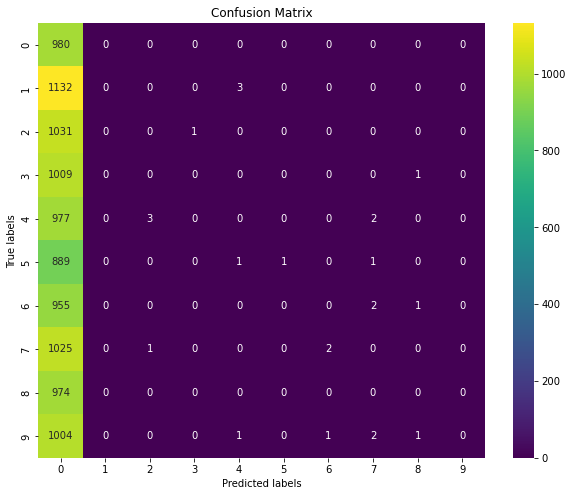

0.0981

In [168]:
my_CNN.test(x_test2, y_test, plot_confusion=True)

## Part (b) - implementing a CNN using PyTorch

**Important:** Now you should restart the runtime so that this notebook is now run using the GPU from Google.

Let us now use `PyTorch` to train a CNN that classify the MNIST digits. Let us first setup the environments.

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import copy
import h5py
from tqdm import tqdm
from random import randint

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms import Compose, Normalize, ToTensor
from torch.autograd import Variable

We then import the MNIST data from the `PyTorch` library and apply some scalings.

In [ ]:
data_transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
mnist_trainset = datasets.MNIST(
    root="./data", train=True, download=True, transform=data_transform,
)
mnist_testset = datasets.MNIST(
    root="./data", train=False, download=True, transform=data_transform,
)

x_train = mnist_trainset.train_data.float().unsqueeze(dim=1)
y_train = mnist_trainset.train_labels
x_test = mnist_testset.test_data.float().unsqueeze(dim=1)
y_test = mnist_testset.test_labels

**Step (1).** We would like to implement a CNN with two convolution layers and one fully-connected layer. Here we use the sigmoid activation function. Modify the cell below to 
- make sure the CNN has the required architecture.
- setup a CNN model, and 
- setup up a SGD optimiser with a fixed learning rate (e.g. `lr=.02`)

*Hint.* 
- You may find the `reshape` function useful in defining the fully-connected layer.
- remember to send the model to the GPU by using teh `.cuda()` command to speed up your simulation!

In [ ]:
class MnistModel(nn.Module):
  def __init__(self):
      super(MnistModel, self).__init__()
        
      # input is 28x28
      self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1) # conv layer 1 
      self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1) # conv layer 2
      
      self.fc = nn.Linear(32 * 7 * 7, 10)  # Fully connected layer 
      
  def forward(self, x):
        # Apply the first convolution
        x = F.max_pool2d(torch.sigmoid(self.conv1(x)), 2)
        # Apply the second convolution
        x = F.max_pool2d(torch.sigmoid(self.conv2(x)), 2)

        # Fully connected layer 
        x = x.view(-1, 32 * 7 * 7)
        x = torch.sigmoid(self.fc(x))
        
        return x

# make sure the model is sent to the GPU
model = MnistModel().cuda()
optimizer = optim.SGD(model.parameters(), lr=0.02) #Stochastic gradient descent optimizer

**Step (2).** Fill in the following code to train our model. (*Hint.* Again, remember to use the `.cuda()` command at appropriate places to speed up your calculations.)

In [ ]:
# Train Model
batch_size = 100
num_epochs = 25
L_Y_train = len(y_train)
model.train()
train_loss = []

for epoch in range(num_epochs):
    
    #Randomly shuffle data every epoch
    I_permutation = np.random.permutation(L_Y_train)
    x_train =  x_train[I_permutation,:]
    y_train =  y_train[I_permutation] 
    train_accu = []

    for i in tqdm(range(0, L_Y_train, batch_size)):
        x_train_batch = torch.FloatTensor( x_train[i:i+batch_size,:])
        y_train_batch = torch.LongTensor( y_train[i:i+batch_size])

        # define the data and target using the Variable() method, and send them to the GPU using the .cuda() method.
        data, target = Variable(x_train_batch).cuda(), Variable(y_train_batch).cuda()

        # implement: 
        # - reset gradient to zero
        optimizer.zero_grad()
        # evaluate output and loss
        output = model(data)
        loss = F.nnl_loss(output, target)
        # compute gradient by .backward()
        loss.backward()
        # append the training loss in the train_loss list.
        train_loss.append(loss.data[0])
        # update the gradient in the optimiser
        optimizer.step()

        #calculate accuracy
        prediction = output.data.max(1)[1]   # first column has actual prob.
        accuracy = (float(prediction.eq(target.data).sum())/float(batch_size))*100.0
        train_accu.append(accuracy)

    accuracy_epoch = np.mean(train_accu)
    print(f"Epoch {epoch}: train accuracy: {accuracy_epoch}%")

**Step (3).** Fill in the following code to test our trained model.

In [ ]:
test_accu = []

for i in range(0, len(y_test), batch_size):
    x_test_batch = torch.FloatTensor(x_test[i:i+batch_size,:])
    y_test_batch = torch.LongTensor(y_test[i:i+batch_size])

    # define the data and target using the Variable() method, and send them to the GPU using the .cuda() method.
    data, target = Variable(x_test_batch).cuda(), Variable(y_test_batch).cuda()

    # reset the gradient in the optimiser to be zero
    optimizer.zero_grad()

    # compute the output and loss
    output = model(data)
    loss = F.nnl_loss(output, target)

    # follow the codes above to compute the test accuracy and append it to the test_accu list.
    prediction = output.data.max(1)[1]   # first column has actual prob.
    accuracy = (float(prediction.eq(target.data).sum())/float(batch_size))*100.0
    train_accu.append(accuracy)
    
accuracy_test = np.mean(test_accu)
print(f"Final test accuracy: {accuracy_test}%")

**Step (4).** Re-run the above cell but changing the activation to `ReLU`. Compare your result with the one when the `sigmoid` activation is used. (*Hint:* Try to run the experiment several times.)

*Edit this cell and note down any special observations here.*

Difference between ReLu and sigmoid activation function: 